<a href="https://colab.research.google.com/github/pasqualemocerino/AILabProj-FaceRecognition/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Face Recognition
Face Recogniton is a form of biometrics, the science which deals with the automated recognition of individuals based on biological and behavioral characteristics. It is included in physiological or static biometrics, based on data derived from the measurement of a part of a person's anatomy.
The main purpose is the authentication of the subject, which follows identification and is based on proving the previously declared identity.

We will later discuss about the advantages and disadvantages of this mechanism, analysing the requirements for an ideal biometric identifier: Universality, Uniqueness, Performance, Collectability, Acceptability.

Face Recognition or Face Identification is: given the picture of the face of an unknown person, identify the name of the person by referring to a gallery of previously seen pictures of identified persons.


###About the dataset
Labeled Faces in the Wild (LFW) is an image dataset containing face photographs, collected especially for studying the problem of unconstrained face recognition. It includes over 13,000 images of faces collected from across the web. Here are key aspects of these images.

Each face in this data set was labeled with the person’s name in the image.
1680 of the photographed persons distinctly appear in two or more photos in the data set.
The faces in these images were detected by the Viola-Jones face detector (Paul Viola and Michael Jones, 2001).

LFW includes four different sets of images, including the original and three types of aligned images that can be used to test algorithms under different conditions. For alignment, the dataset uses funneled images (ICCV 2007), LFW-a, and deep funneled images (NIPS 2012). Deep funneled and LFW-a images produce superior results for most face verification algorithms over the funneled images and the original images.

Face Recognition is a task typically performed on the output of a model trained to perform Face Detection. The most popular model for Face Detection is called Viola-Jones and is implemented in the OpenCV library. The LFW faces were extracted by this face detector from various online websites.

###Purpose
Our first purpose is to create a pretrained model in order to achieve an identity-based accurate classification of a dataset of well-known faces. Then we will make the neural network recognize further faces using new measurements linked to proper identity labels. A final objective could be to make an app which recognize human faces after collecting data.

#FaceNet
FaceNet is a deep neural network used for extracting features from an image of a person’s face. It was published in 2015 by Google researchers.

FaceNet takes an image of the person’s face as input and outputs a vector of 128 numbers which represent the most important features of a face. In machine learning, this vector is called embedding. Why embedding? Because all the important information from an image is embedded into this vector. Basically, FaceNet takes a person’s face and compresses it into a vector of 128 numbers. Ideally, embeddings of similar faces are also similar.

FaceNet learns in the following way:

1. Randomly selects an anchor image.
2. Randomly selects an image of the same person as the anchor image (positive example).
3. Randomly selects an image of a person different than the anchor image (negative example).
4. Adjusts the FaceNet network parameters so that the positive example is closer to the anchor than the negative example.

We repeat these steps until there are no more changes to be done, so all the faces of the same person are close to each other and far from others.

This method of learning with anchor, positive and negative examples is called triplet loss.

The classification step could be done by calculating the embedding distances between a new face and known faces, but that approach is too computationally and memory expensive (this approach is called k-NN). Instead, we decided to use the Softmax classifier which memorises boundaries between people which is much more efficient.

#Schedule
1. Pre-processing — a method used to take a set of images and convert them all to a uniform format — in our case, a square image containing just a person’s face. A uniform dataset is useful for decreasing variance when training as we have limited computational resources when using the Edge TPU.
2. Embedding — a process, fundamental to the way FaceNet works, which learns representations of faces in a multidimensional space where distance corresponds to a measure of face similarity.
3. Classification — the final step which uses information given by the embedding process to separate distinct faces.

##1. Pre-processing


###1.1. Basic steps.

In [104]:
%matplotlib inline

In [105]:
import os
import torch 
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [110]:
# Hyperparameters
BATCH_SIZE = 16
WORKERS = 0 if os.name == 'nt' else 2

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the dataset
print("[INFO] Loading the LFW dataset...")
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((160,160)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.LFWPeople(root='./data', transform = transform, download=True)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=WORKERS)
print("[INFO] Dataset loaded:")
print(dataset)

[INFO] Loading the LFW dataset...
Files already downloaded and verified
[INFO] Dataset loaded:
Dataset LFWPeople
    Number of datapoints: 13233
    Root location: ./data/lfw-py
    Alignment: funneled
    Split: 10fold
    Classes (identities): 5749
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Extracting identities as classes.

In [113]:
from sklearn.datasets import fetch_lfw_people

In [114]:
lfw_people = fetch_lfw_people(min_faces_per_person=1, resize=0.4)
classes = lfw_people.target_names

Display a single batch of images from dataset.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def imshow(img):
  # Unnormalizing
  img = img/2 + 0.5 
  # Plotting
  plt.imshow(np.transpose(img.numpy(), (1,2,0)))

In [116]:
dataiter = iter(dataloader)

George W Bush       Muffet McGraw       Wu Yi               Harland Braun       Carol Burnett       David Nalbandian    Joe Glover          Edward Lu           
Julio Cesar Chavez  Wang Yingfan        Sidney Poitier      Fujio Cho           Colin Powell        Donald Rumsfeld     Richard Naughton    John Negroponte     

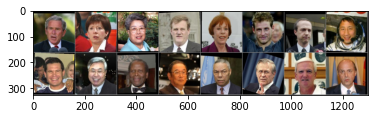

In [115]:
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

padding = 1
names = [classes[labels[id]] for id in range(BATCH_SIZE)]

# Column width (using padding)
col_width = max(len(name) for name in names) + padding 

for i in range(len(names)):
  if (i == 8): print()
  print(names[i].ljust(col_width), end=' ')

###1.2. MTCNN
One face landmark detector that has proven to work very well for face alignment in this setting is the Multi-task CNN (MTCNN).

####mtcnn

A first possibility is to use the package mtcnn.

1. Initialization.

In [117]:
%pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import cv2
import mtcnn
from mtcnn.mtcnn import MTCNN

image_path = "/content/data/lfw-py/lfw_funneled/Bill_Clinton/Bill_Clinton_0004.jpg"
print("Versione di MTCNN:", mtcnn.__version__)

Versione di MTCNN: 0.1.0


2. Define a method to detect face in an image using MTCNN, returning bounding boxes.

In [9]:
#Defining a face detector
def face_detector(image):
  detector = MTCNN()
  bboxes = detector.detect_faces(image)
  return bboxes

3.  Define a method to draw bounding box around the face in an image.

In [10]:
#Drawing function
def draw_bounding_boxes(image, bboxes):
    for box in bboxes:
        x, y, w, h = box['box']
        cv2.rectangle(image, (x, y), (x+w,y+h), (0,255,0), 2)

4. Define a method to mark keypoints on face.

In [11]:
#Keypoints mark on face
def mark_keypoints(image, keypoints):
  cv2.circle(image, (keypoints), 1, (0,255,0), 2)

5. Test with an image to detect a face.

In [12]:
#Image processing
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes = face_detector(image)
print("Output of MTCNN detector: \n", bboxes)

Output of MTCNN detector: 
 [{'box': [70, 55, 107, 143], 'confidence': 0.9999871253967285, 'keypoints': {'left_eye': (91, 109), 'right_eye': (135, 110), 'nose': (106, 136), 'mouth_left': (96, 157), 'mouth_right': (135, 159)}}]


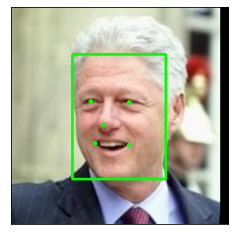

In [13]:
# Drawing bounding box around face and marking keypoints
draw_bounding_boxes(image, bboxes)
mark_keypoints(image, bboxes[0]['keypoints']['left_eye'])
mark_keypoints(image, bboxes[0]['keypoints']['right_eye'])
mark_keypoints(image, bboxes[0]['keypoints']['nose'])
mark_keypoints(image, bboxes[0]['keypoints']['mouth_left'])
mark_keypoints(image, bboxes[0]['keypoints']['mouth_right'])

# Display the image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

In [14]:
def crop_face(image, bboxes):
    for box in bboxes:
        x, y, w, h = box['box']
        return image[y:y+h, x:x+w]

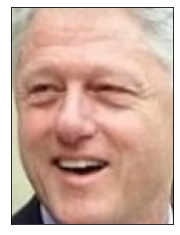

In [123]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

face = crop_face(image,bboxes)
plt.imshow(face)
plt.xticks([])
plt.yticks([])
plt.show()

However, mtcnn is good to work an a single image, but works very slowly on batches. The output should also be squared, with equal width and height (resize needed). Let's try another approach.

####facenet-pytorch
A batched face detection of a MTCNN is implemented in the facenet-pytorch package.

In [16]:
%pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.6 MB/s 


#####Verify how it works on a single image.

In [17]:
from PIL import Image
from facenet_pytorch import MTCNN, training

In [18]:
# Face detector
mtcnn = MTCNN(margin=15, 
              select_largest=False, 
              post_process=False, 
              device=device)

# Processing an image
img = Image.open("/content/data/lfw-py/lfw_funneled/Bill_Clinton/Bill_Clinton_0004.jpg")

# Detect face, returning cropped and prewhitened image tensor
face = mtcnn(img)

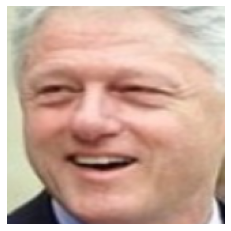

In [19]:
# Visualize
plt.imshow(face.permute(1, 2, 0).int().numpy())
plt.axis('off');
plt.show()

#####Now we works with batched detection.

######1. Set parameters.

In [20]:
data_dir = '/content/data/lfw-py/lfw_funneled'
pairs_path = '/content/data/lfw-py/lfw_funneled/pairs.txt'

In [21]:
print('Running on device: {}'.format(device))

Running on device: cuda


######2. Build the MTCNN.

In [58]:
mtcnn = MTCNN(
    image_size=160,
    margin=15,
    device=device,
    selection_method='center_weighted_size'
)

######3. Define the data loader.

In [51]:
input_loader = datasets.ImageFolder(root=data_dir, transform=None)

######4. Overwrite class labels with path used to save output.

In [52]:
# Overwriting class labels with path
input_loader.samples = [(p, p) for p, _ in input_loader.samples]

# Data loader for the input set of images
img_loader = DataLoader(input_loader, 
                    batch_size= BATCH_SIZE, 
                    num_workers= WORKERS,
                    collate_fn=training.collate_pil
          )

######5. Build a new folder containing cropped images of faces. Now we works on batches.

In [25]:
# (Optional) Command to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [60]:
face_paths = []

print("[INFO] Processing...")
for i, (images, b_paths) in enumerate(img_loader):
    faces = [p.replace(data_dir, data_dir + '_faces') for p in b_paths]
    mtcnn(images, save_path=faces)
    face_paths.extend(faces)
    print('\rCropping faces of batch {} of {}'.format(i+1, len(img_loader)), end='')
print("\n[INFO] Process ended.")

[INFO] Processing...
Cropping faces of batch 828 of 828
[INFO] Process ended.


######6. Remove MTCNN to reduce GPU memory usage and empty CUDA cache.

In [27]:
del mtcnn
torch.cuda.empty_cache()

##2. Embedding

We will give the output faces of MTCNN as inputs to Inception net, in order to obtain embeddings of faces.

###2.1 Prepare input for Inception-ResNet v1

We will use Inception-Resnet v1 instead of the second version. Althought their working principles are the same, Inception-ResNet v2 is more accurate, but has a higher computational cost than the previous Inception-ResNet v1 network.

This network is a hybrid between the Inception v4 and ResNet, the key functionality of the Inception-ResNet is that the output of the inception module is added to the input.

In [61]:
from torch.utils.data import SubsetRandomSampler, SequentialSampler
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization, extract_face

In [29]:
# Dataset and dataloader from output faces of MTCNN

transform = transforms.Compose([
  np.float32,
  transforms.ToTensor(),
  fixed_image_standardization
])

dataset = datasets.ImageFolder(root=data_dir + '_faces', transform=transform)

face_loader = DataLoader(
    dataset,
    num_workers = WORKERS,
    batch_size = BATCH_SIZE,
    sampler = SequentialSampler(dataset)
)

###2.2 Load a pretrained net for embedding

We load a model trained on large dataset VGGFace2.

In [30]:
resnet = InceptionResnetV1(
    classify=False,
    pretrained='vggface2'
).to(device).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

###2.3 Calculate embeddings 

We are going to calculate 512-bit embeddings, instead of the 128-bit embeddngs described in FaceNet paper.

In [68]:
# Arrays of 13233 elements each one (number of elements of dataset)
classes = [] # Labels in the range [0,5748] (5749 possible identities)
embeddings = [] # 512-bit elements

print("[INFO] Processing...")
i=0
with torch.no_grad():
  for faces, labels in face_loader:
    faces = faces.to(device)
    i += 1

    #Batch embeddings
    print('\rCalculating embeddings of batch {} of {}'.format(i, len(face_loader)), end='')
    b_embd = resnet(faces)
    b_embd = b_embd.to('cpu').numpy()
    classes.extend(labels.numpy())
    embeddings.extend(b_embd)
print("\n[INFO] Process ended.")

[INFO] Processing...
Calculating embeddings of batch 828 of 828
[INFO] Process ended.


###2.4 Save embeddings to relative paths

In [32]:
embeddings_dict = dict(zip(face_paths,embeddings))

##3. Classification

###3.1 Importing necessary dependencies

In [33]:
import math
from sklearn.model_selection import KFold
from scipy import interpolate

###3.2 Define a metric

In [34]:
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidean distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric

    return dist

###3.3 Calculate ROC (Receiver Operating Characteristic) for the classifier

Define a function to calculate TPR (True Positive Rate), FPR (False Positive Rate) and accuracy.

In [35]:
def calculate_accuracy(threshold, dist, actual_issame):
    # Verify if dist < threshold
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))

    is_fp = np.logical_and(predict_issame, np.logical_not(actual_issame))
    is_fn = np.logical_and(np.logical_not(predict_issame), actual_issame)

    # True positive rate
    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    # False positive rate
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    # Accuracy
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc, is_fp, is_fn

Calculate ROC.

In [36]:
# We use a k-Fold Cross-Validation with k=10
def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    n_pairs = min(len(actual_issame), embeddings1.shape[0])
    n_thresholds = len(thresholds)
    # K-Fold CV
    k_fold = KFold(n_splits=folds, shuffle=False)

    # True positive rates
    tprs = np.zeros((folds,n_thresholds))
    # False positive rates
    fprs = np.zeros((folds,n_thresholds))
    # Accuracy array (length of folds) 
    accuracy = np.zeros((folds))

    is_false_positive = []
    is_false_negative = []

    # Indices from 0 to n_pairs - 1
    indices = np.arange(n_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        # Calculate Euclidean distance (distance_metric=0)
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the best threshold for the fold
        acc_train = np.zeros((n_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx], _ ,_ = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _, _, _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx], is_fp, is_fn = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])

        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
        is_false_positive.extend(is_fp)
        is_false_negative.extend(is_fn)

    return tpr, fpr, accuracy, is_false_positive, is_false_negative

###3.4 Calculate performances of the classifier

Define a function to calculate TAR (True Acceptance Rate) and FAR (False Acceptance Rate).

In [37]:
def calculate_val_far(threshold, dist, actual_issame):
    # Verify if dist < threshold
    predict_issame = np.less(dist, threshold)
    # True acceptance
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    # False acceptance
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))

    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))

    # True Acceptance Rate (TAR)
    val = float(true_accept) / float(n_same)
    # False Acceptance Rate (FAR)
    far = float(false_accept) / float(n_diff)

    return val, far

Calculate performances.

In [38]:
def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    n_pairs = min(len(actual_issame), embeddings1.shape[0])
    n_thresholds = len(thresholds)
    k_fold = KFold(n_splits=folds, shuffle=False)

    val = np.zeros(folds)
    far = np.zeros(folds)

    # Indices from 0 to n_pairs - 1
    indices = np.arange(n_pairs)

    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)

        # Find the threshold that gives FAR = far_target (given as parameter)
        far_train = np.zeros(n_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train)>=far_target:
            # Interpolation (1-D function)
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0

        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])

    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    
    return val_mean, val_std, far_mean

###3.5 Evaluate the model on LFW dataset

We evaluate performances of Face Verification task, based on comparison of embedding pairs.

In [64]:
def evaluate(embeddings, actual_issame, folds=10, distance_metric=0, subtract_mean=False):
    # Calculate evaluation metrics
    thresholds = np.arange(0, 4, 0.01)
    embeddings1 = embeddings[0::2]
    embeddings2 = embeddings[1::2]


    # Calculate ROC
    tpr, fpr, accuracy, fp, fn  = calculate_roc(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), folds=folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    
    thresholds = np.arange(0, 4, 0.001)

    # Calculate validation
    val, val_std, far = calculate_val(thresholds, embeddings1, embeddings2,
        np.asarray(actual_issame), 1e-3, folds=folds, distance_metric=distance_metric, subtract_mean=subtract_mean)
    
    return tpr, fpr, accuracy, val, val_std, far, fp, fn

Define some utility functions.

In [40]:
def read_pairs(pairs_filename):
    pairs = []
    with open(pairs_filename, 'r') as f:
        for line in f.readlines()[1:]:
            pair = line.strip().split()
            pairs.append(pair)
    return np.array(pairs, dtype=object)

In [41]:
def add_extension(path):
    if os.path.exists(path+'.jpg'):
        return path+'.jpg'
    elif os.path.exists(path+'.png'):
        return path+'.png'
    else:
        raise RuntimeError('No file "%s" with extension png or jpg.' % path)

In [42]:
def get_paths(lfw_dir, pairs):
    n_skipped_pairs = 0
    path_list = []
    issame_list = []
    for pair in pairs:
        if len(pair) == 3:
            path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
            path1 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[2])))
            issame = True
        elif len(pair) == 4:
            path0 = add_extension(os.path.join(lfw_dir, pair[0], pair[0] + '_' + '%04d' % int(pair[1])))
            path1 = add_extension(os.path.join(lfw_dir, pair[2], pair[2] + '_' + '%04d' % int(pair[3])))
            issame = False
        # Only add the pair if both paths exist
        if os.path.exists(path0) and os.path.exists(path1):  
            path_list += (path0,path1)
            issame_list.append(issame)
        else:
            n_skipped_pairs += 1
    if n_skipped_pairs>0:
        print('Skipped %d image pairs' % n_skipped_pairs)

    return path_list, issame_list

Evaluate the model.

In [43]:
pairs = read_pairs(pairs_path)
path_list, issame_list = get_paths(data_dir+'_faces', pairs)
embeddings = np.array([embeddings_dict[path] for path in path_list])

tpr, fpr, accuracy, val, val_std, far, fp, fn = evaluate(embeddings, issame_list)

In [71]:
print("Accuracy for each of the 10 folds:\n")
print(accuracy,"\n")
print("Accuracy mean: ")
np.mean(accuracy)

Accuracy for each of the 10 folds:

[0.99666667 0.99333333 0.99166667 0.985      0.99       0.99666667
 0.99       0.99666667 0.99166667 0.99833333] 

Accuracy mean: 


0.993

In [45]:
print("True Positive Rate (TPR):", np.mean(tpr))
print("False Positive Rate (FPR):", np.mean(fpr))
print('Validation: {} +/- {}'.format("%.4f" % round(val,4), "%.4f" % round(val_std,4)))
print("False Acceptance Rate (FAR):", far)

True Positive Rate (TPR): 0.8827708333333334
False Positive Rate (FPR): 0.5107408333333333
Validation: 0.9840 +/- 0.0104
False Acceptance Rate (FAR): 0.001
